# Homework 10- Spatial Data Analysis (Two season)
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from geopandas import GeoDataFrame
import os
from fiona.crs import from_epsg
import matplotlib as mpl
import statsmodels.api as sm
import shapely
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pysal as ps
import seaborn as sns
from matplotlib import colors
%matplotlib inline

## Working with Shape File

### Loading Census Tract Shape File¶

In [3]:
shape_path= os.getenv("PUIDATA")+"/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010
ct_shape.head(2)

BoroCT2010 BoroCode       BoroName CDEligibil  CT2010 CTLabel  \
BoroCT2010                                                                 
5000900       5000900        5  Staten Island          I  000900       9   
5012500       5012500        5  Staten Island          I  012500     125   

           NTACode                                    NTAName  PUMA  \
BoroCT2010                                                            
5000900       SI22  West New Brighton-New Brighton-St. George  3903   
5012500       SI22  West New Brighton-New Brighton-St. George  3903   

              Shape_Area    Shape_Leng  \
BoroCT2010                               
5000900     2.497010e+06   7729.016729   
5012500     4.954936e+06  10582.855530   

                                                     geometry  
BoroCT2010                                                     
5000900     POLYGON ((-74.07920577013245 40.64343078374566...  
5012500     POLYGON ((-74.11618948747538 40.62894119691981...

### Coordinate systems, projections, and transformations 

In [4]:
# epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
ct_shape.crs = from_epsg(4326)
# from ft2 to mi2 
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) 
# from ft2 to mi2 #epsg=2263 is US feet
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] 

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

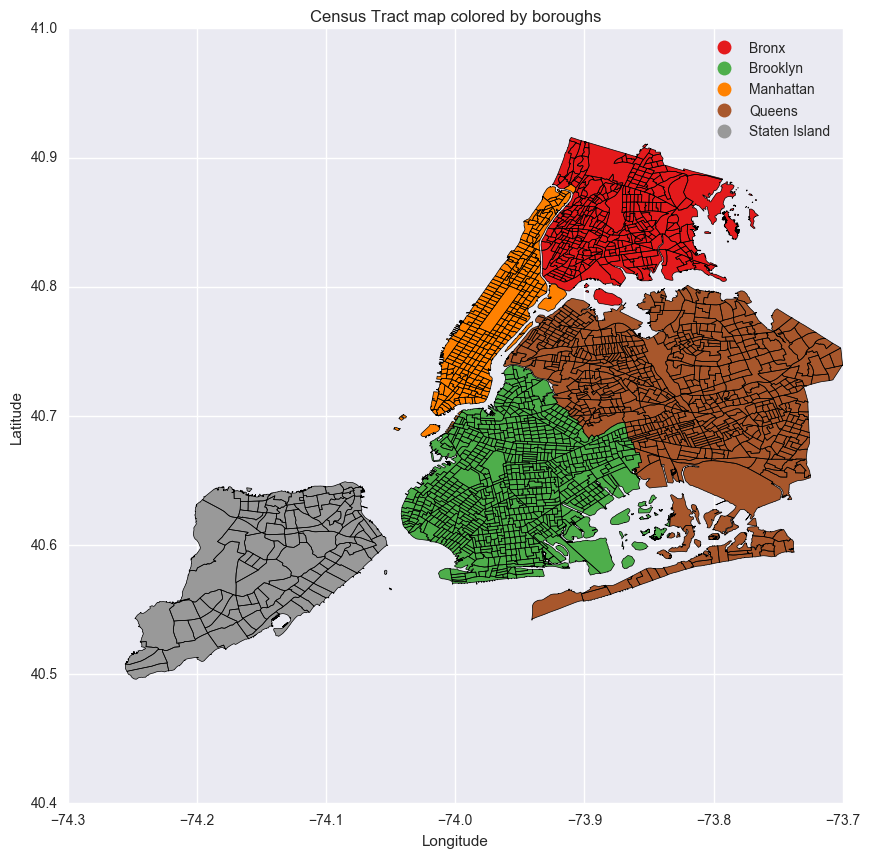

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ct_shape.plot(column='BoroName',alpha=1,linewidth=0.5,ax=ax, legend=True)
plt.title("Census Tract map colored by boroughs")

### Map NYC Population density

#### Load Census Data for 2010

In [6]:
ct_data=DataFrame.from_csv('ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)
ct_data.head(2)

BoroCT2010          Geo_NAME  \
BoroCT2010                                 
5000900        5000900    Census Tract 9   
5012500        5012500  Census Tract 125   

                                              Geo_QName     Geo_FIPS  \
BoroCT2010                                                             
5000900       Census Tract 9, Richmond County, New York  36085000900   
5012500     Census Tract 125, Richmond County, New York  36085012500   

            Geo_SUMLEV  Geo_GEOCOMP  Geo_STATE  Geo_COUNTY  Geo_COUNTYSC  \
BoroCT2010                                                                 
5000900            140            0         36          85            19   
5012500            140            0         36          85            19   

            Geo_COUSUB     ...       SE_T017_017  SE_T017_018  SE_T017_019  \
BoroCT2010                 ...                                               
5000900            NaN     ...                32           23           13   
5012500            NaN     ...                50           50           28   

            SE_T017_020  SE_T017_021  SE_T017_022  SE_T017_023  SE_T017_024  \
BoroCT2010                                                                    
5000900              12           10           12           11            7   
5012500              33           36           32           42           20   

            SE_T017A001  SE_T017A002  
BoroCT2010                            
5000900             746           50  
5012500            1522           89  

[2 rows x 257 columns]

#### Add popuation density to CT shapefile

In [7]:
ct_shape_pop=ct_shape.join(ct_data['SE_T002_002']) 
#SE_T002_002 is population density in social explorer dataset without unit
ct_shape_pop.head(2)

BoroCT2010 BoroCode       BoroName CDEligibil  CT2010 CTLabel  \
BoroCT2010                                                                 
5000900       5000900        5  Staten Island          I  000900       9   
5012500       5012500        5  Staten Island          I  012500     125   

           NTACode                                    NTAName  PUMA  \
BoroCT2010                                                            
5000900       SI22  West New Brighton-New Brighton-St. George  3903   
5012500       SI22  West New Brighton-New Brighton-St. George  3903   

              Shape_Area    Shape_Leng  \
BoroCT2010                               
5000900     2.497010e+06   7729.016729   
5012500     4.954936e+06  10582.855530   

                                                     geometry  SE_T002_002  
BoroCT2010                                                                  
5000900     POLYGON ((-74.07920577013245 40.64343078374566...     23590.33  
5012500     POLYGON ((-74.11618948747538 40.62894119691981...     16629.33

#### Vusualize the Population density for 2010

/Users/YueCai/anaconda/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


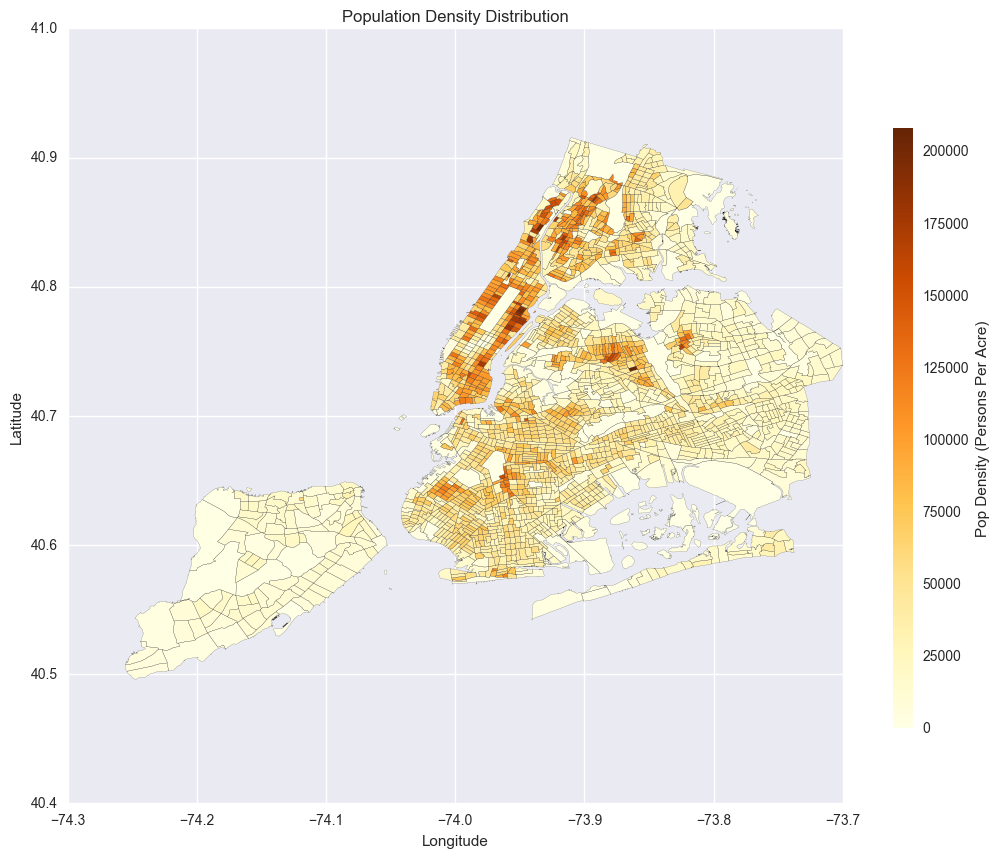

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ct_shape_pop.plot(column='SE_T002_002',colormap='YlOrBr',alpha=1,linewidth=0.1,ax=ax,)

plt.title("Population Density Distribution")

norm = mpl.colors.Normalize(vmin=ct_shape_pop['SE_T002_002'].min(),
                              vmax=ct_shape_pop['SE_T002_002'].max())

#http://stackoverflow.com/questions/25505674/python-matplotlib-add-colorbar
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='YlOrBr', norm=norm, spacing='proportional')
cb.set_label('Pop Density (Persons Per Acre)')

In [9]:
len(ct_data['SE_T002_002'])

2166

In [10]:
sum(ct_data['SE_T002_002'] != 0)

2142

In [11]:
sum(ct_data['SE_T002_002'] == 0)

24

In [12]:
sum(ct_data['SE_T002_002'].isnull().values)

2

Incomplete data, that's why somewhere in the map shows zero people per acre

## Explore CitiBike data

### Load CitiBike data

In [13]:
df_bike_monthly=DataFrame.from_csv('CitiBike_monthly_byStation.csv')
df_bike_monthly.head(2)

1000  1001  1002  1003  1004  1005  1006  1007  1008  1009  ...   \
starttime                                                               ...    
2013-07-31  2343  3914  6979  2750  4914  2229  2183  3139  3622  2368  ...    
2013-08-31  2696  4429  9020  3433  6645  2768  2761  3422  4271  2910  ...    

            1533  1534  1535  1536  1537  1538  1539  1540  1541  1542  
starttime                                                               
2013-07-31     0     0     0     0     0     0     0     0     0     0  
2013-08-31     0     0     0     0     0     0     0     0     0     0  

[2 rows x 543 columns]

### Time Series Aanalysis

Here we divide whole year data into two seasons:
#### Shoulder season: April- October (when people biking much, because of weather condition)
#### Low season : November- March (when people not biking much, because of weather condition) 

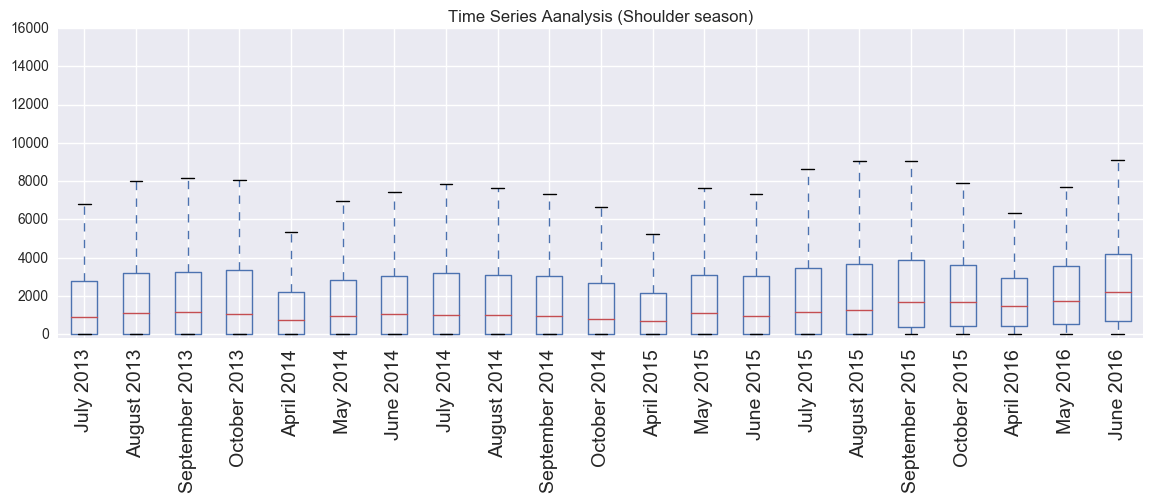

In [14]:
Riders_in_shoulderseason = df_bike_monthly[(df_bike_monthly.index.month >= 4) &
                                 (df_bike_monthly.index.month <= 10)]
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots(figsize=(14,4))
Riders_in_shoulderseason_= Riders_in_shoulderseason.copy()
Riders_in_shoulderseason_.index = Riders_in_shoulderseason_.index.strftime("%B %Y")
Riders_in_shoulderseason_.T.boxplot(figsize=(15,7), ax=ax, rot=90)
ax.set_ylim([-200,16000])  
ax.set_title("Time Series Aanalysis (Shoulder season)")

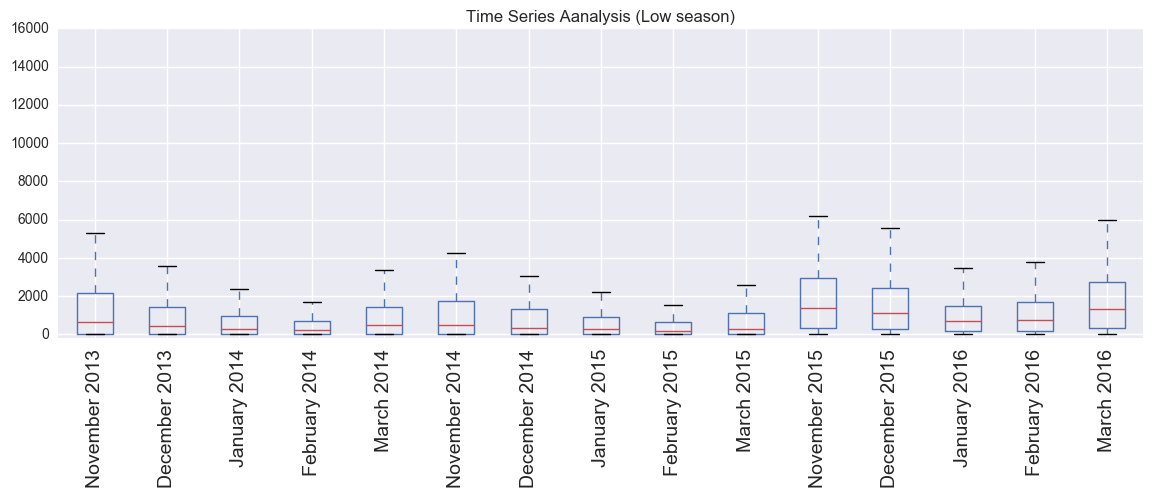

In [15]:
Riders_in_lowseason = df_bike_monthly[(df_bike_monthly.index.month == 11)|
                                      (df_bike_monthly.index.month == 12)|
                                      (df_bike_monthly.index.month == 1)|
                                      (df_bike_monthly.index.month == 2)|
                                      (df_bike_monthly.index.month == 3)]
plt.rcParams['font.size'] = 14                                                       
fig, ax = plt.subplots(figsize=(14,4))
Riders_in_lowseason_= Riders_in_lowseason.copy()
Riders_in_lowseason_.index = Riders_in_lowseason_.index.strftime("%B %Y")
Riders_in_lowseason_.T.boxplot(figsize=(15,7), ax=ax, rot=90)
ax.set_ylim([-200,16000])  
ax.set_title("Time Series Aanalysis (Low season)")

#### Seasonal Decomposition

/Users/YueCai/anaconda/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


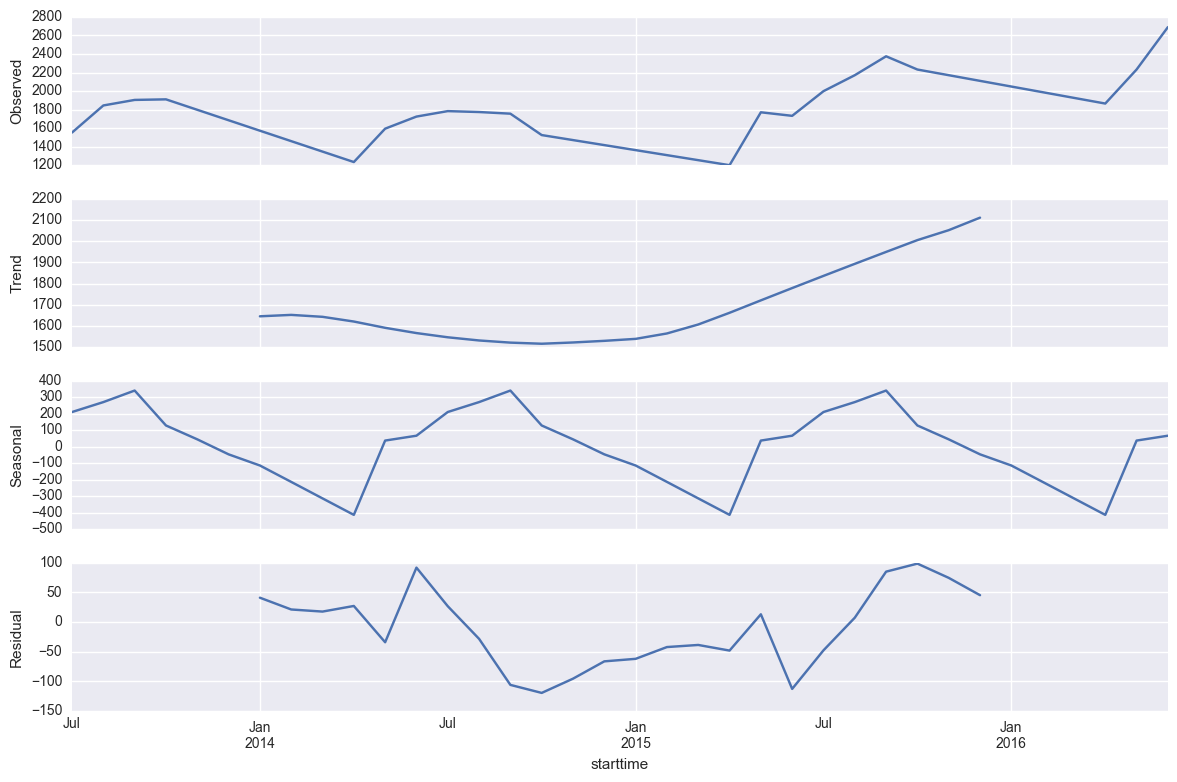

In [16]:
SS_df_new = Riders_in_shoulderseason.mean(1).resample('M').mean()
SS_df_new.interpolate(inplace=True)
SS_res = sm.tsa.seasonal_decompose(SS_df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
#plt.title("Seasonal Decomposition (Shoulder season)")
SS_resplot = SS_res.plot()

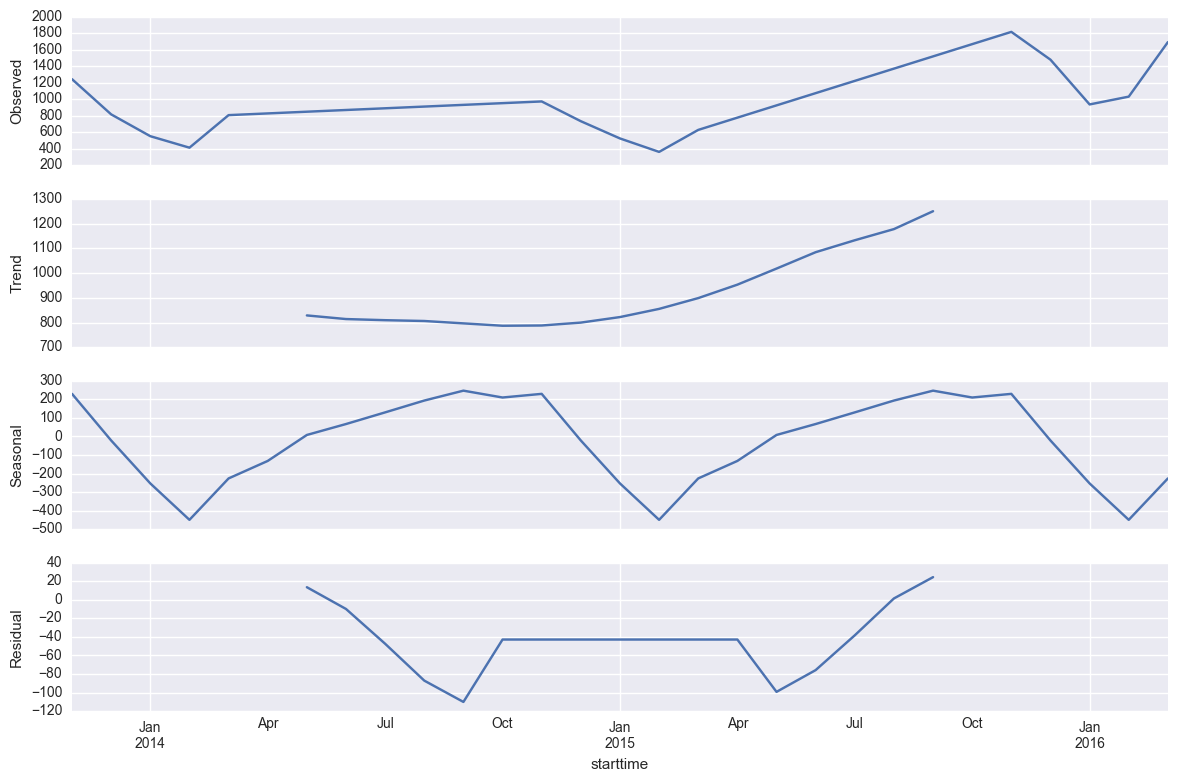

In [17]:
LS_df_new = Riders_in_lowseason.mean(1).resample('M').mean()
LS_df_new.interpolate(inplace=True)
LS_res = sm.tsa.seasonal_decompose(LS_df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
#plt.title("Seasonal Decomposition (Low season)")
LS_resplot = LS_res.plot()

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [18]:
station_id=DataFrame.from_csv('Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head(2)

lat        lon
1000  40.753231 -73.970325
1001  40.749718 -74.002950

### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [19]:
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head(2)

lat        lon                         lonlat  \
1000  40.753231 -73.970325    (-73.97032517, 40.75323098)   
1001  40.749718 -74.002950  (-74.002950346, 40.749717753)   

                                     geometry  
1000         POINT (-73.97032517 40.75323098)  
1001  POINT (-74.00295034600001 40.749717753)

### Intersect the two geometries

In [20]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects
                      (station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a

% 100.


In [21]:
station_id.BoroCT2010.head(2)

1000    1009000
1001    1009900
Name: BoroCT2010, dtype: object

### Add Shoulder Season rides to the station GeoDataFrame with CT code

In [22]:
# Shoulder season: April- October
# Create average Shoulder season rides column from monthly citibike data 
# and add it to the station id which has the geometry
Riders_in_shoulderseason = df_bike_monthly[(df_bike_monthly.index.month >= 4) &
                                 (df_bike_monthly.index.month <= 10)]
station_id['SSAvg'] = Riders_in_shoulderseason.sum()
station_id['SSAvg'].head(2) 

1000    50567
1001    79025
Name: SSAvg, dtype: int64

### Add Low Season rides to the station GeoDataFrame with CT code

In [23]:
# Low season : November- March
# Create average Low season rides column from monthly citibike data 
# and add it to the station id which has the geometry
Riders_in_lowseason = df_bike_monthly[(df_bike_monthly.index.month == 11)|
                                      (df_bike_monthly.index.month == 12)|
                                      (df_bike_monthly.index.month == 1)|
                                      (df_bike_monthly.index.month == 2)|
                                      (df_bike_monthly.index.month == 3)]
station_id['LSAvg'] = Riders_in_lowseason.sum()
station_id['LSAvg'].head(2) 

1000    18741
1001    23799
Name: LSAvg, dtype: int64

In [24]:
station_id.head(2)

lat        lon                         lonlat  \
1000  40.753231 -73.970325    (-73.97032517, 40.75323098)   
1001  40.749718 -74.002950  (-74.002950346, 40.749717753)   

                                     geometry BoroCT2010  SSAvg  LSAvg  
1000         POINT (-73.97032517 40.75323098)    1009000  50567  18741  
1001  POINT (-74.00295034600001 40.749717753)    1009900  79025  23799

### Add the SS and LS average rides to the CT shapefile 

In [25]:
temp = station_id[['SSAvg', 'LSAvg']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_seasons = ct_shape.join(temp)
ct_shape_seasons.fillna(0, inplace=True)
temp.head()

/Users/YueCai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


SSAvg  LSAvg station_id
BoroCT2010                          
1009000      50567  18741       1000
1009900      79025  23799       1001
1005700     199411  74114       1002
1001800      74333  27616       1003
1006100     138201  45843       1004

### Shoulder Season Ridership Plot

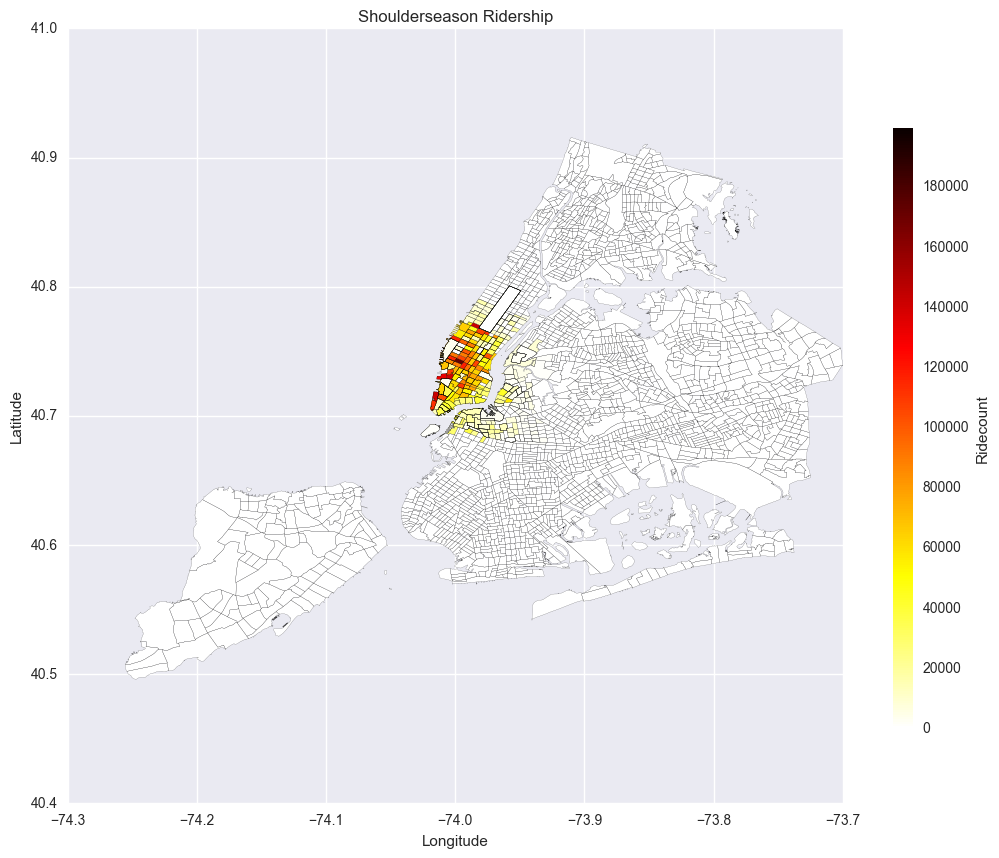

In [26]:
fig, ax = plt.subplots(figsize=(10,10))

ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ct_shape_seasons.plot(column='SSAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax,)
plt.title("Shoulderseason Ridership")
norm = mpl.colors.Normalize(vmin=ct_shape_seasons['SSAvg'].min(),
                              vmax=ct_shape_seasons['SSAvg'].max())

#http://stackoverflow.com/questions/25505674/python-matplotlib-add-colorbar
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='hot_r', norm=norm, spacing='proportional')
cb.set_label('Ridecount')

### Low Season Ridership Plot

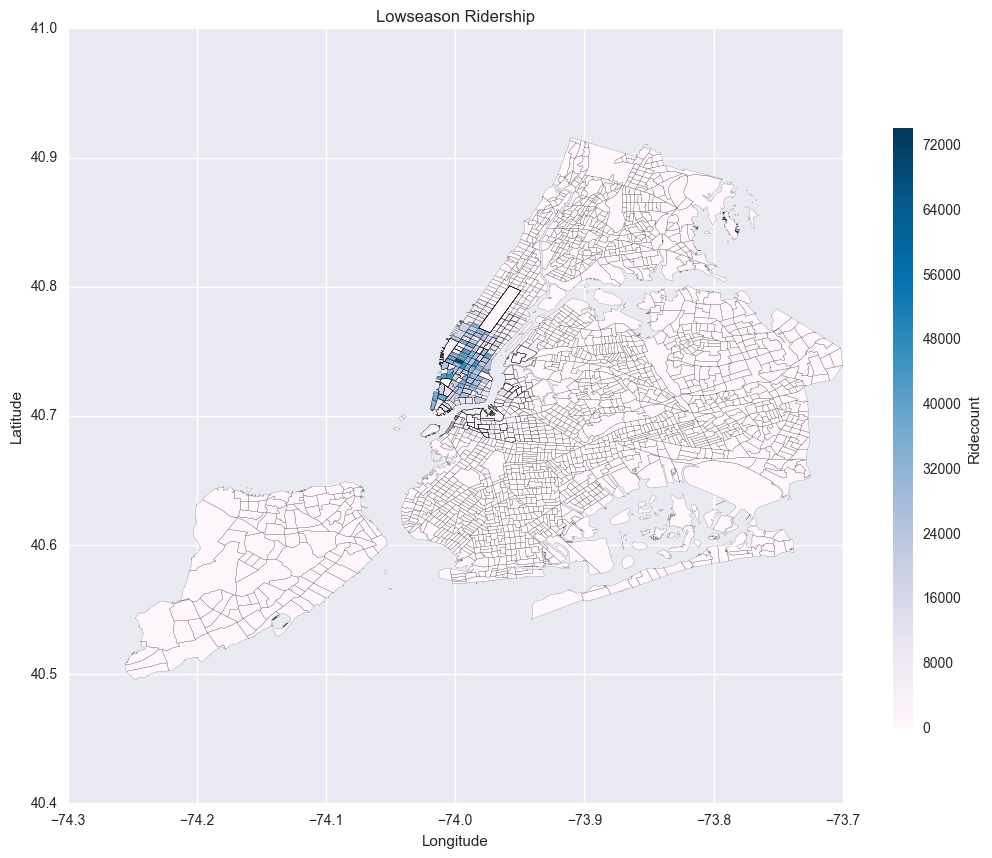

In [27]:
fig, ax = plt.subplots(figsize=(10,10))

ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

ct_shape_seasons.plot(column='LSAvg',colormap='PuBu',alpha=1,linewidth=0.1,ax=ax)
plt.title("Lowseason Ridership")
norm = mpl.colors.Normalize(vmin=ct_shape_seasons['LSAvg'].min(),
                              vmax=ct_shape_seasons['LSAvg'].max())

#http://stackoverflow.com/questions/25505674/python-matplotlib-add-colorbar
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='PuBu', norm=norm, spacing='proportional')
cb.set_label('Ridecount')

### Removing the CTs that are out of zoom boundries for both seasons

In [28]:
ct_shape_seasons_zoom = (ct_shape_seasons[
        ct_shape_seasons.centroid.apply(
            lambda c: c.x > -74.05 and c.x < -73.92 and
            c.y > 40.67 and c.y < 40.8)])

In [29]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(ct_shape_seasons_zoom)

Total number of CTs: 2166
Number of zoomed CTs: 723


### Map the Shoulder Season Rideship 

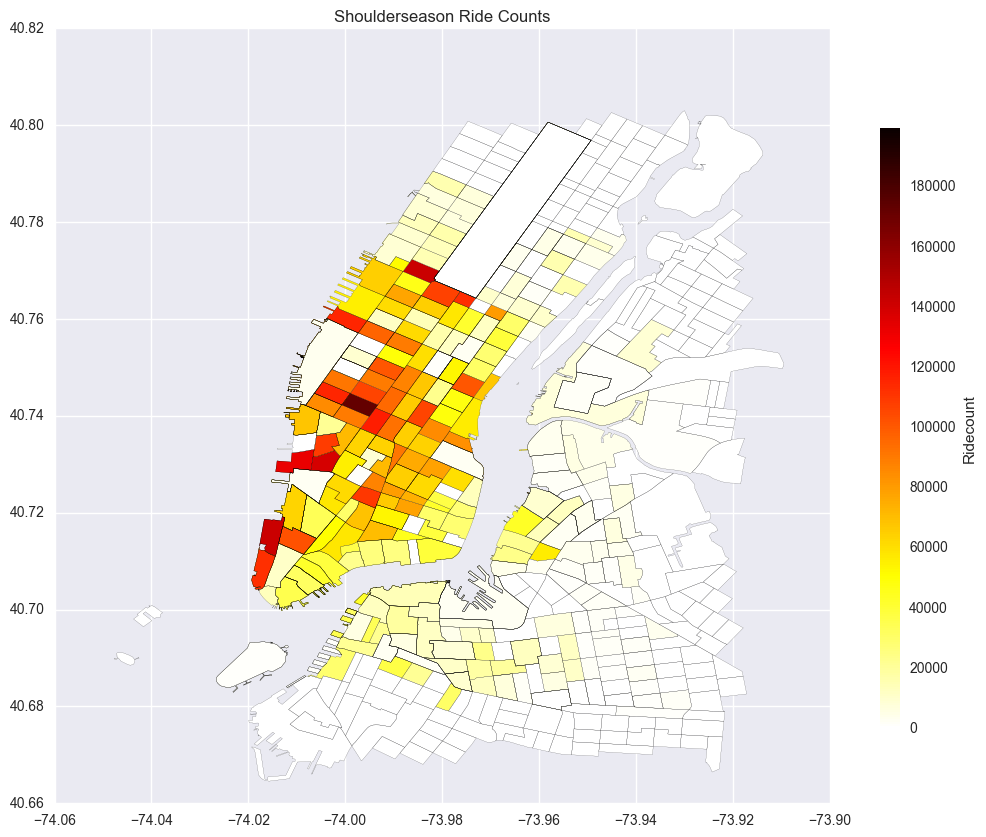

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ct_shape_seasons_zoom.plot(column='SSAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Shoulderseason Ride Counts")

norm = mpl.colors.Normalize(vmin=ct_shape_seasons_zoom['SSAvg'].min(),
                              vmax=ct_shape_seasons_zoom['SSAvg'].max())

#http://stackoverflow.com/questions/25505674/python-matplotlib-add-colorbar
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='hot_r', norm=norm, spacing='proportional')
cb.set_label('Ridecount')

### Map the Low Season Rideship 

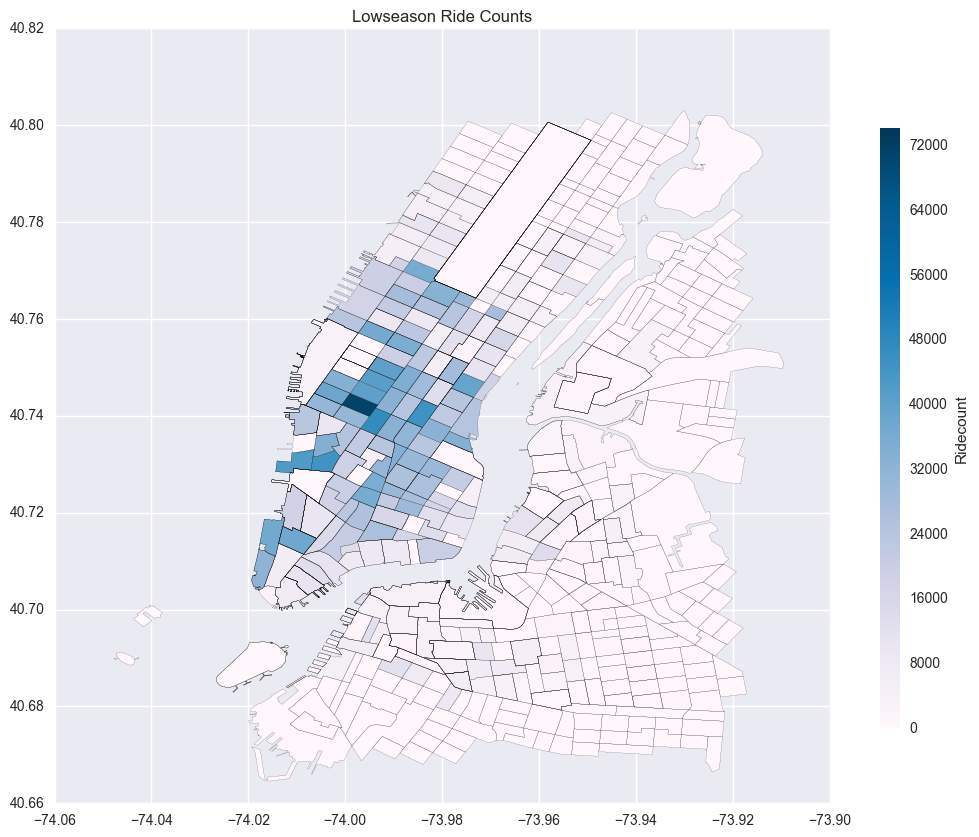

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(True)
ax.get_yaxis().set_visible(True)
ct_shape_seasons_zoom.plot(column='LSAvg',colormap='PuBu',alpha=1,linewidth=0.1,ax=ax)
plt.title("Lowseason Ride Counts")

norm = mpl.colors.Normalize(vmin=ct_shape_seasons_zoom['LSAvg'].min(),
                              vmax=ct_shape_seasons_zoom['LSAvg'].max())

#http://stackoverflow.com/questions/25505674/python-matplotlib-add-colorbar
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax, cmap='PuBu', norm=norm, spacing='proportional')
cb.set_label('Ridecount')

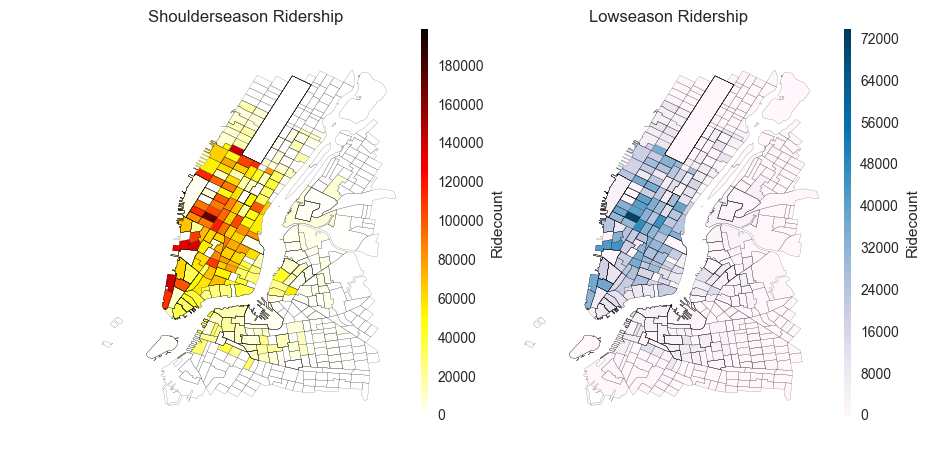

In [32]:
fig,ax = plt.subplots(figsize=(10,5))

ax1 = plt.subplot(121)
ax1.get_xaxis().set_visible(True)
ax1.get_yaxis().set_visible(True)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ct_shape_seasons_zoom.plot(column='SSAvg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax1,)
plt.title("Shoulderseason Ridership")
norm = mpl.colors.Normalize(vmin=ct_shape_seasons_zoom['SSAvg'].min(),
                              vmax=ct_shape_seasons_zoom['SSAvg'].max())
#http://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar
divider1 = make_axes_locatable(ax1)
cax = divider1.append_axes("right", size="2%", pad=0.05)
cb = mpl.colorbar.ColorbarBase(cax, cmap='hot_r', norm=norm, spacing='proportional')
cb.set_label('Ridecount')
ax1.set_axis_off()

ax2 = plt.subplot(122)
ax2.get_xaxis().set_visible(True)
ax2.get_yaxis().set_visible(True)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ct_shape_seasons_zoom.plot(column='LSAvg',colormap='PuBu',alpha=1,linewidth=0.1,ax=ax2)
plt.title("Lowseason Ridership")
norm = mpl.colors.Normalize(vmin=ct_shape_seasons_zoom['LSAvg'].min(),
                              vmax=ct_shape_seasons_zoom['LSAvg'].max())
#http://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar
divider2 = make_axes_locatable(ax2)
cax = divider2.append_axes("right", size="2%", pad=0.05)
cb = mpl.colorbar.ColorbarBase(cax, cmap='PuBu', norm=norm, spacing='proportional')
cb.set_label('Ridecount')
ax2.set_axis_off()

### Export Shapefile CTs in the CitiBike Zone

In [33]:
path='ct_shape_seasons_zoom.shp'
ct_shape_seasons_zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Queen contigutiy weight, which reflects adjacency relationships as a binary indicator variable denoting whether or not a polygon shares an edge or a vertex with another polygon. 

In [34]:
qW_CT=ps.queen_from_shapefile(path)
dataframe = ps.pdio.read_files(path)
dataframe.head(2)

('Island id: ', [0])


BoroCT2010 BoroCode   BoroName CDEligibil  CT2010 CTLabel NTACode  \
0    1000100        1  Manhattan          I  000100       1    MN99   
1    1000201        1  Manhattan          E  000201    2.01    MN28   

                       NTAName  PUMA    Shape_Area    Shape_Leng  SSAvg  \
0  park-cemetery-etc-Manhattan  3810  1.844421e+06  11023.047911    0.0   
1              Lower East Side  3809  9.716282e+05   4748.703650    0.0   

   LSAvg station_id                                         geometry  
0    0.0          0  <pysal.cg.shapes.Polygon object at 0x13d595a90>  
1    0.0          0  <pysal.cg.shapes.Polygon object at 0x12af2bc90>

#### Test on Neighbors 

In [35]:
qW_CT.n # there are 723 qW_CT neighbors in total

723

In [36]:
qW_CT.mean_neighbors

14.19640387275242

In [37]:
qW_CT.max_neighbors

42

In [38]:
qW_CT.min_neighbors

0

A close look on a specific example, for instance: neighbors of index 10

In [39]:
qW_CT.cardinalities[10]

9

In [40]:
qW_CT.neighbors[10]

[1, 37, 38, 39, 8, 9, 18, 19, 30]

#### Matrix of Weights

In [41]:
#A full and dense matrix describing all of the pairwise relationships is constructed 
Wmatrix, ids = qW_CT.full()
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [42]:
qW_CT.transform = 'r' # 'o' will change back to ordinary

('WARNING: ', 0, ' is an island (no neighbors)')


In [43]:
# row-standardized
Wmatrix, ids = qW_CT.full()
Wmatrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.14285714, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.08333333,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.16666667,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.16666667,
         0.        ,  0.16666667],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.5       ,  0.        ]])

### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [44]:
SSRide = ct_shape_seasons_zoom.SSAvg
SSRideLag = ps.lag_spatial(qW_CT, SSRide)
SSRideLag.size

723

In [45]:
LSRide = ct_shape_seasons_zoom.LSAvg
LSRideLag = ps.lag_spatial(qW_CT, LSRide)
LSRideLag.size

723

#### Create Quantiles for maping

In [46]:
#Quantiles for Shoulder Season
SSRideLagQ10 = ps.Quantiles(SSRideLag, k=10) # 10 clusters
print SSRideLagQ10

                   Quantiles                    
 
  Lower                Upper               Count
             x[i] <=      0.000               81
     0.000 < x[i] <=   1728.098               64
  1728.098 < x[i] <=   4961.100               72
  4961.100 < x[i] <=  10047.250               72
 10047.250 < x[i] <=  15130.800               74
 15130.800 < x[i] <=  29114.867               71
 29114.867 < x[i] <=  50269.880               72
 50269.880 < x[i] <=  62730.109               72
 62730.109 < x[i] <=  72883.594               72
 72883.594 < x[i] <= 110254.714               73


In [47]:
# Quantiles for Low Season
LSRideLagQ10 = ps.Quantiles(LSRideLag, k=10) #10 clusters
print LSRideLagQ10

                  Quantiles                   
 
  Lower              Upper               Count
            x[i] <=     0.000               86
    0.000 < x[i] <=   832.715               59
  832.715 < x[i] <=  2086.968               72
 2086.968 < x[i] <=  3995.931               72
 3995.931 < x[i] <=  5485.600               74
 5485.600 < x[i] <= 10499.679               71
10499.679 < x[i] <= 17795.946               72
17795.946 < x[i] <= 21905.248               72
21905.248 < x[i] <= 26414.904               72
26414.904 < x[i] <= 41728.643               73


### Map the Shoulderseason Rides Lag

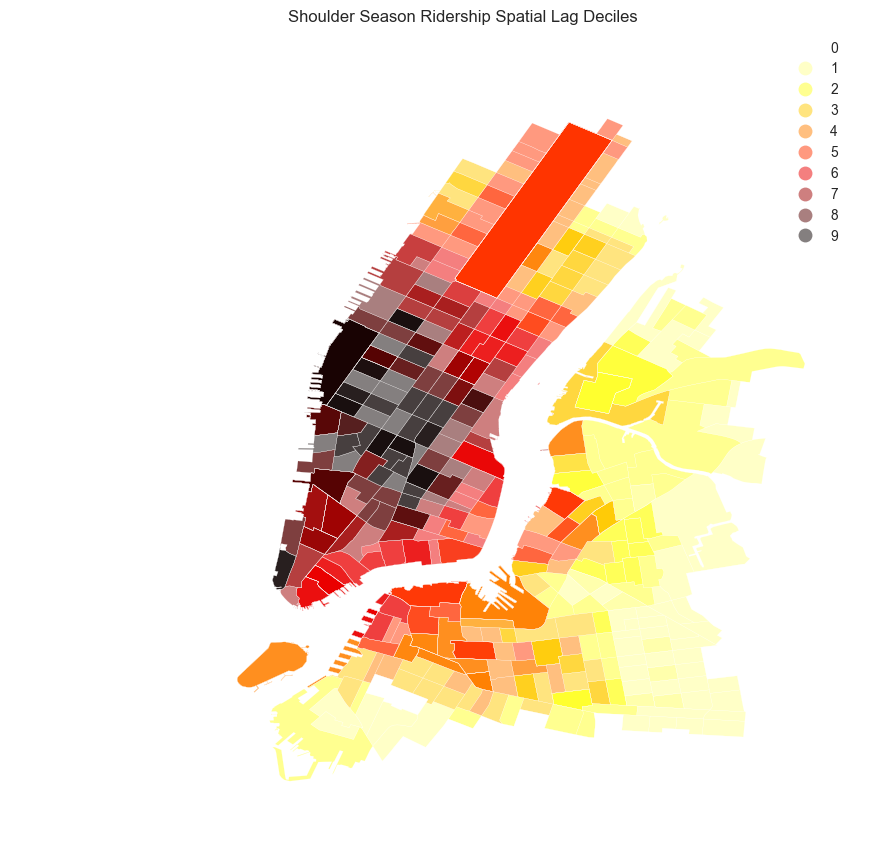

In [48]:
fig, ax = plt.subplots(figsize=(10,10))

ct_shape_seasons_zoom.assign(cl=SSRideLagQ10.yb).plot(column='cl',
        categorical=True, k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
ax.set_title('Shoulder Season Ridership Spatial Lag Deciles')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# The colors indicate the spatial distribution of Shoulder Season Ridership, in terms of Quantiles 

### Map the Low Season Rides Lag

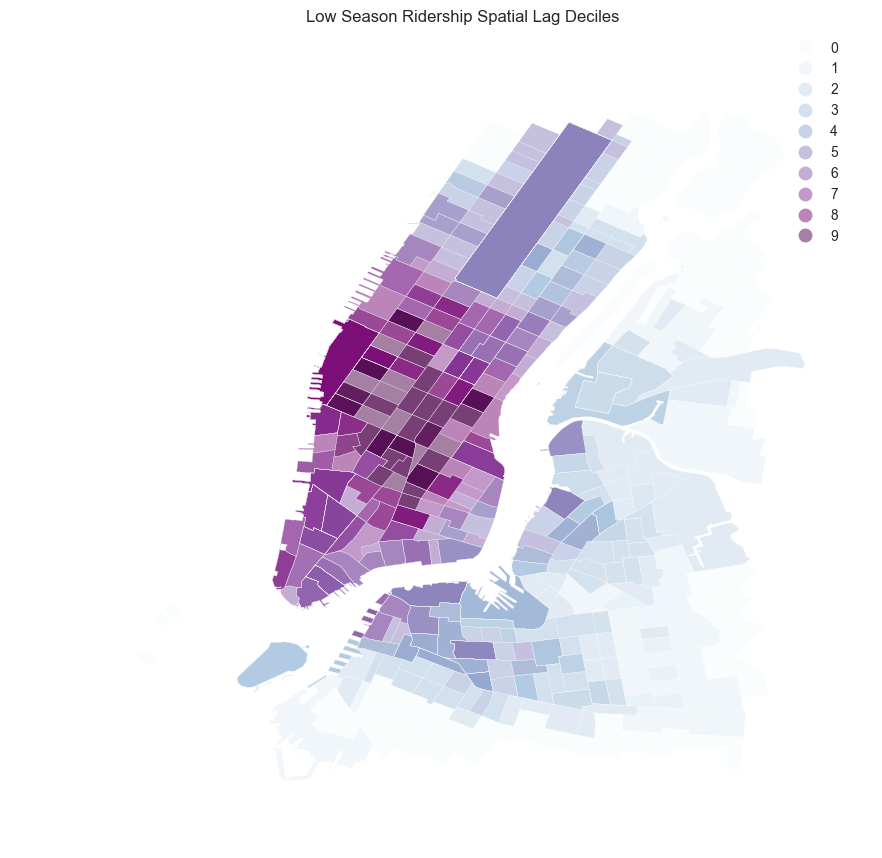

In [49]:
fig, ax = plt.subplots(figsize=(10,10))

ct_shape_seasons_zoom.assign(cl=LSRideLagQ10.yb).plot(column='cl', 
        categorical=True, k=10, cmap='BuPu', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
ax.set_title('Low Season Ridership Spatial Lag Deciles')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# The colors indicate the spatial distribution of Shoulder Season Ridership, in terms of Quantiles 

## Global  Spatial Autocorrelation

In [50]:
b0, a0 = np.polyfit(SSRide, SSRideLag, 1)
print b0, a0 

b1, a1 = np.polyfit(LSRide, LSRideLag, 1)
print b1, a1 

0.62736730827 10985.9339192
0.642457689493 3804.42040284


### Moran Scatterplot

Moran Scatterplot is a simple scatter plot in which a given variable is plotted against its own spatial lag.

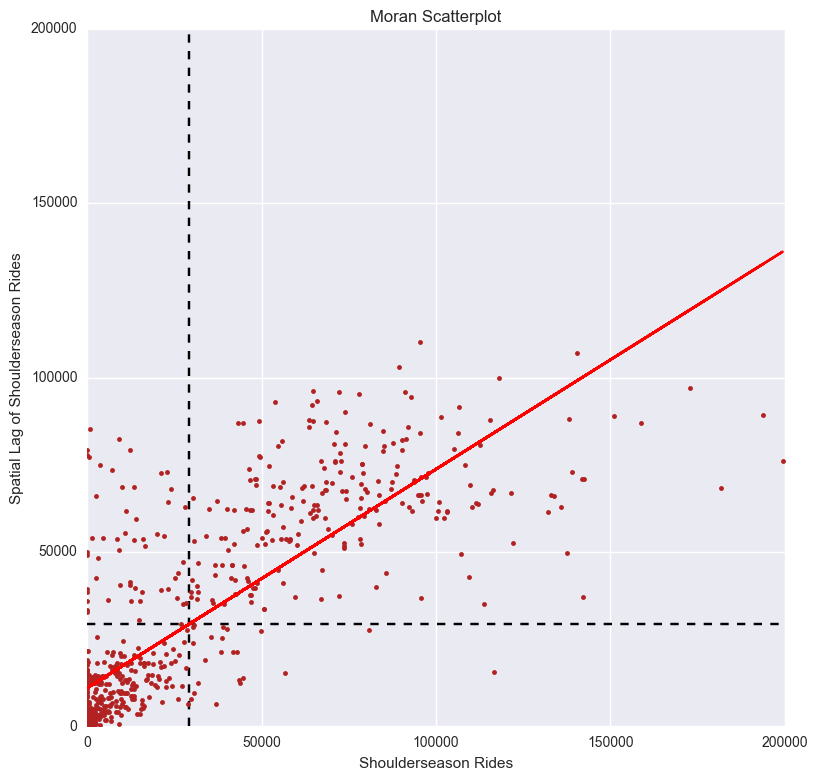

In [51]:
fig, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(SSRide , SSRideLag , '.', color='firebrick')

plt.vlines(SSRide.mean(), SSRide.min(), SSRide.max(), linestyle='--')

plt.hlines(SSRideLag.mean(), SSRide.min(), SSRide.max(), linestyle='--')

plt.plot(SSRide, a0 + b0*SSRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Shoulderseason Rides')
plt.xlabel('Shoulderseason Rides')

In this plot, the Shoulderseason Rides is poltted against its own spatial lag.

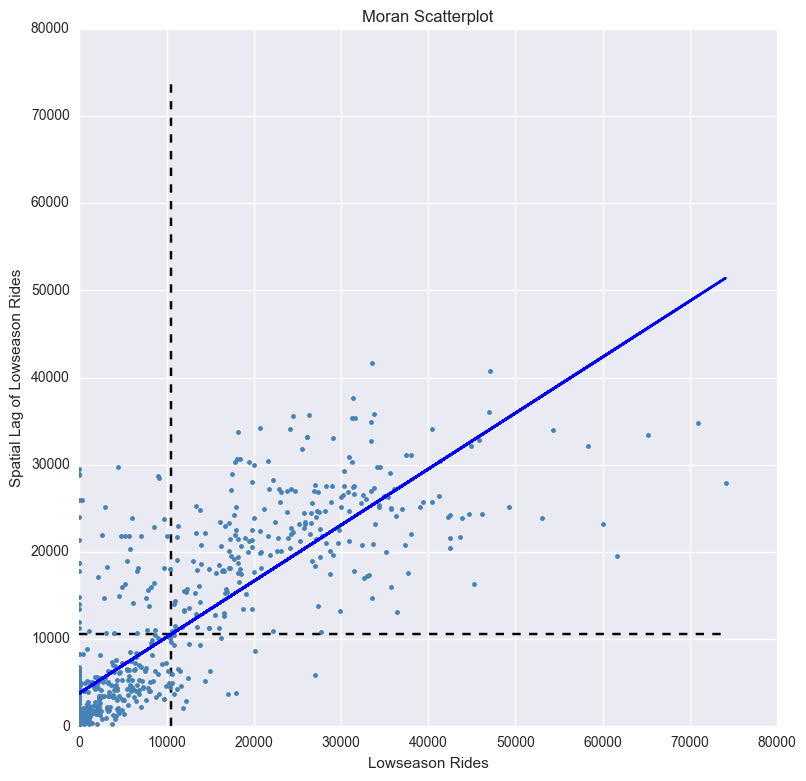

In [52]:
fig, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(LSRide , LSRideLag , '.', color='steelblue')

plt.vlines(LSRide.mean(), LSRide.min(), LSRide.max(), linestyle='--')

plt.hlines(LSRideLag.mean(), LSRide.min(), LSRide.max(), linestyle='--')

plt.plot(LSRide, a1 + b1*LSRide, 'b')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Lowseason Rides')
plt.xlabel('Lowseason Rides')

In this plot, the Low Rides is poltted against its own spatial lag.

### Moran's I

In [53]:
I_SSRide = ps.Moran(SSRide, qW_CT)
I_LSRide = ps.Moran(LSRide, qW_CT)

In [54]:
I_SSRide.I, I_SSRide.p_sim

(0.6273978433023415, 0.001)

Thus, the $I$ statistic is $0.627$ for Shoulder season, and has a very small $p$ value. 

In [55]:
I_LSRide.I, I_LSRide.p_sim

(0.64247589063881416, 0.001)

Thus, the $I$ statistic is $0.642$ for Low season, and has a very small $p$ value. 

In [56]:
I_SSRide.sim[0:10]

array([ 0.01412428,  0.04376429, -0.00341499,  0.00084976,  0.0151444 ,
        0.00085328, -0.02164889, -0.00900731, -0.00751341,  0.01661668])

In [57]:
I_LSRide.sim[0:10]

array([ 0.01350675,  0.02136056, -0.02427971,  0.0230989 ,  0.00427887,
       -0.03158002, -0.01549755, -0.00756286,  0.01204804,  0.00054125])

### KDEplot of all of the simulated points
the vertical line shows the observed value

(-0.7, 0.7)

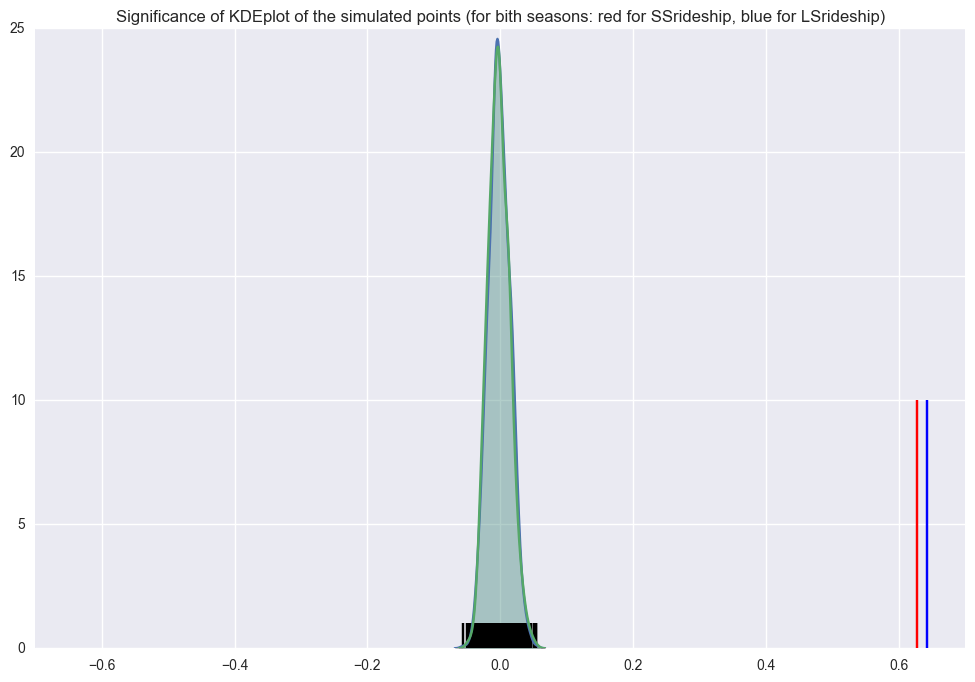

In [58]:
plt.title('Significance of KDEplot of the simulated points (for bith seasons:\
 red for SSrideship, blue for LSrideship)')
plt.rcParams['figure.figsize']=(14,3)
sns.kdeplot(I_SSRide.sim, shade=True)
plt.vlines(I_SSRide.sim, 0, 1)
plt.vlines(I_SSRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

plt.rcParams['figure.figsize']=(14,3)
sns.kdeplot(I_LSRide.sim, shade=True)
plt.vlines(I_LSRide.sim, 0, 1)
plt.vlines(I_LSRide.I, 0, 10, 'b')
plt.xlim([-.70, .70])

In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

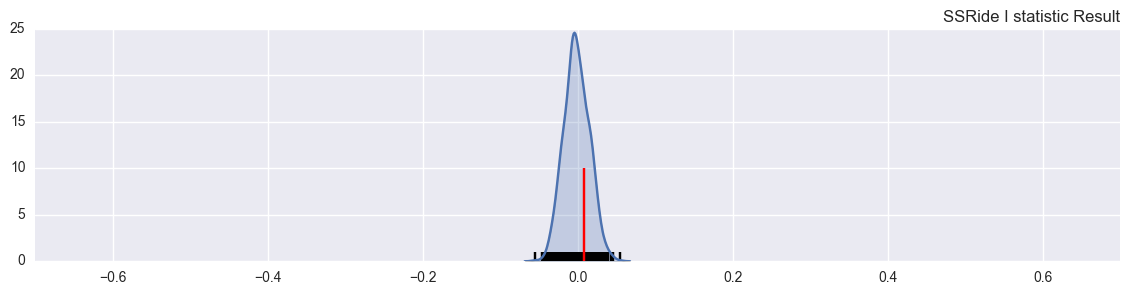

In [59]:
plt.rcParams['figure.figsize']=(14,3)
sns.kdeplot(I_SSRide.sim, shade=True)
plt.vlines(I_SSRide.sim, 0, 1)
plt.vlines(I_SSRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])
plt.title('SSRide I statistic Result', loc = 'right')

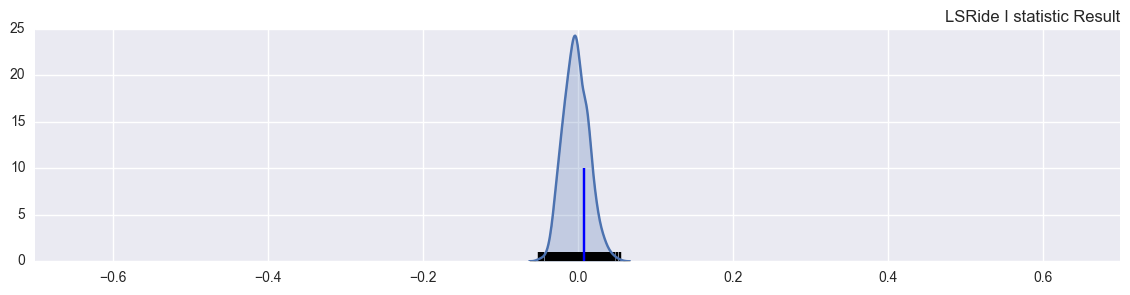

In [60]:
plt.rcParams['figure.figsize']=(14,3)
sns.kdeplot(I_LSRide.sim, shade=True)
plt.vlines(I_LSRide.sim, 0, 1)
plt.vlines(I_LSRide.EI+.01, 0, 10, 'b')
plt.xlim([-.70, .70])
plt.title('LSRide I statistic Result', loc = 'right')

## Local  Spatial Autocorrelation

In [61]:
LMo_SSRide = ps.Moran_Local(SSRide, qW_CT,permutations=999)
LMo_SSRide.Is[0:5], LMo_SSRide.p_sim[0:5]

/Users/YueCai/anaconda/lib/python2.7/site-packages/pysal/esda/moran.py:835: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/YueCai/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/YueCai/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/YueCai/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1731: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


(array([ -0.00000000e+00,  -1.93821758e-01,  -1.52935083e-04,
         -2.36642708e-04,  -5.87667371e-03]),
 array([ 0.001,  0.265,  0.484,  0.471,  0.479]))

In [62]:
LMo_LSRide = ps.Moran_Local(LSRide, qW_CT,permutations=999)
LMo_LSRide.Is[0:5], LMo_LSRide.p_sim[0:5]

(array([-0.        , -0.25414853,  0.01258894, -0.00179799, -0.10546415]),
 array([ 0.001,  0.185,  0.422,  0.393,  0.335]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [63]:
sigs0 = SSRide[LMo_SSRide.p_sim <= .001]
W_sigs0 = SSRideLag[LMo_SSRide.p_sim <= .001]
insigs0 = SSRide[LMo_SSRide.p_sim > .001]
W_insigs0 = SSRideLag[LMo_SSRide.p_sim > .001]

In [64]:
sigs1 = LSRide[LMo_LSRide.p_sim <= .001]
W_sigs1 = LSRideLag[LMo_LSRide.p_sim <= .001]
insigs1 = LSRide[LMo_LSRide.p_sim > .001]
W_insigs1 = LSRideLag[LMo_LSRide.p_sim > .001]

### Plot Signficant LISA

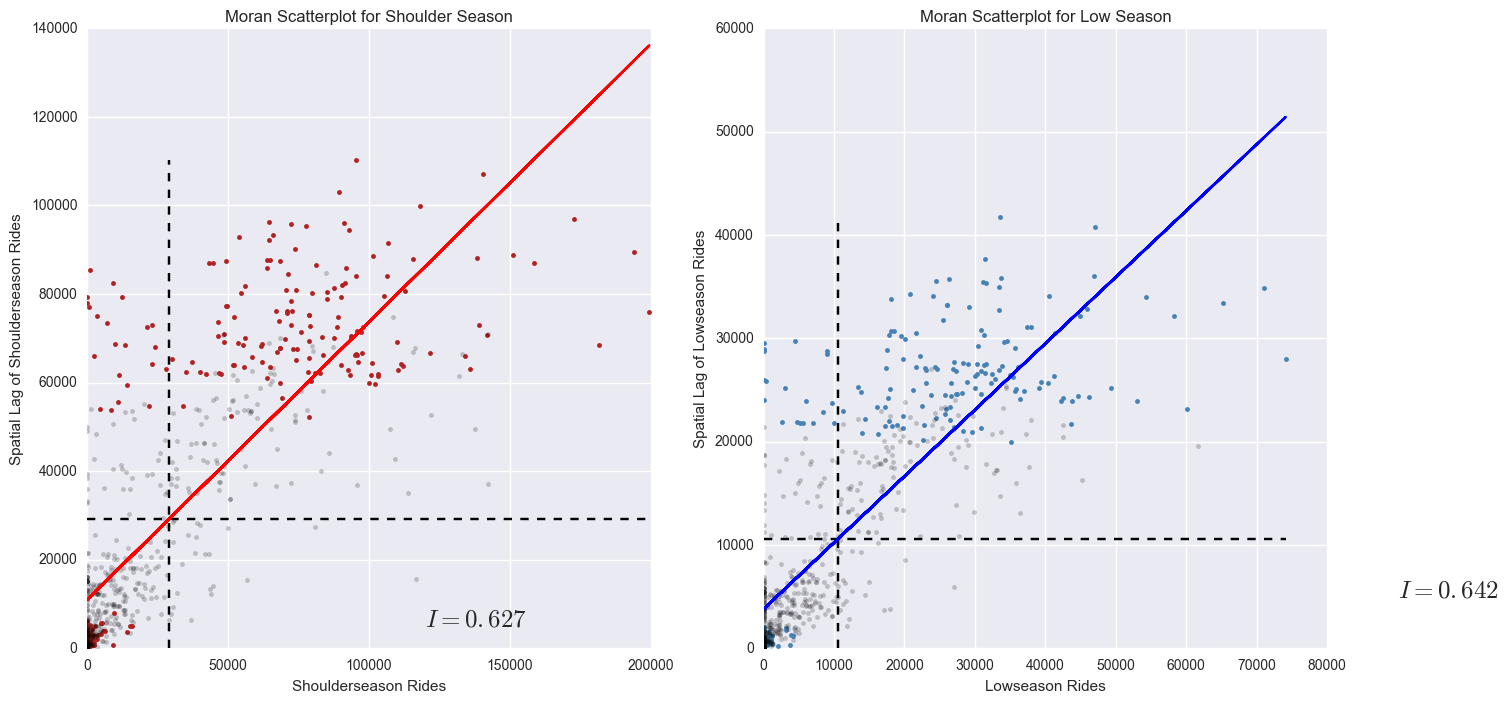

In [65]:
fig, ax = plt.subplots(figsize=(16, 8))

ax1 = plt.subplot(121)
plt.plot(sigs0, W_sigs0, '.', color='firebrick')
plt.plot(insigs0, W_insigs0, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_SSRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(SSRide.mean(), SSRideLag.min(), SSRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(SSRideLag.mean(), SSRide.min(), SSRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(SSRide, a0 + b0*SSRide, 'r')
plt.title('Moran Scatterplot for Shoulder Season')
plt.ylabel('Spatial Lag of Shoulderseason Rides')
plt.xlabel('Shoulderseason Rides')

ax2 = plt.subplot(122)
plt.plot(sigs1, W_sigs1, '.', color='steelblue')
plt.plot(insigs1, W_insigs1, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_LSRide.I, x=90000, y=5000, fontsize=18)

plt.vlines(LSRide.mean(), LSRideLag.min(), LSRideLag.max(), linestyle='--')

plt.hlines(LSRideLag.mean(), LSRide.min(), LSRide.max(), linestyle='--')

plt.plot(LSRide, a1 + b1*LSRide, 'b')
plt.title('Moran Scatterplot for Low Season')
plt.ylabel('Spatial Lag of Lowseason Rides')
plt.xlabel('Lowseason Rides')

For both plots, the colored points indicate the amount of local spatial autocorrelation in both defined seasons, although there are slightly different between the two seasons, in term of Moran's I vaule (LISA) . In this sense, the rideship during low season has little higher Spatial Autocorrelation tendency than the shoulder season does.

### Hot and Cold spots 

In [66]:
# Shoulder season
sig0 = LMo_SSRide.p_sim < 0.01
hotspots0 = LMo_SSRide.q==1 * sig0
coldspots0 = LMo_SSRide.q==3 * sig0
print "Number of Hotspots during shoulder season:", hotspots0.sum()
print "Number of Coldspots during shoulder season:", coldspots0.sum()

Number of Hotspots during shoulder season: 181
Number of Coldspots during shoulder season: 246


In [67]:
# Low season
sig1 = LMo_LSRide.p_sim < 0.01
hotspots1 = LMo_LSRide.q==1 * sig1
coldspots1 = LMo_LSRide.q==3 * sig1
print "Number of Hotspots during low season:", hotspots1.sum()
print "Number of Coldspots during low season:", coldspots1.sum()

Number of Hotspots during low season: 177
Number of Coldspots during low season: 230


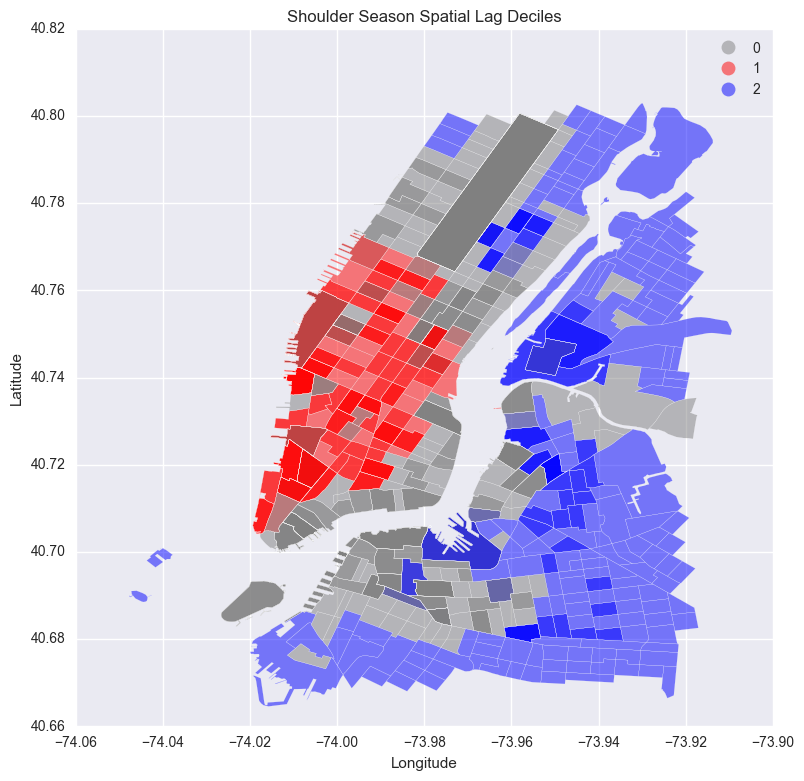

In [68]:
# Shoulder Season Spatial Autocorrelation Analysis
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold0 = hotspots0*1 + coldspots0*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_seasons_zoom.assign(cl=hotcold0).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title("Shoulder Season Spatial Lag Deciles")

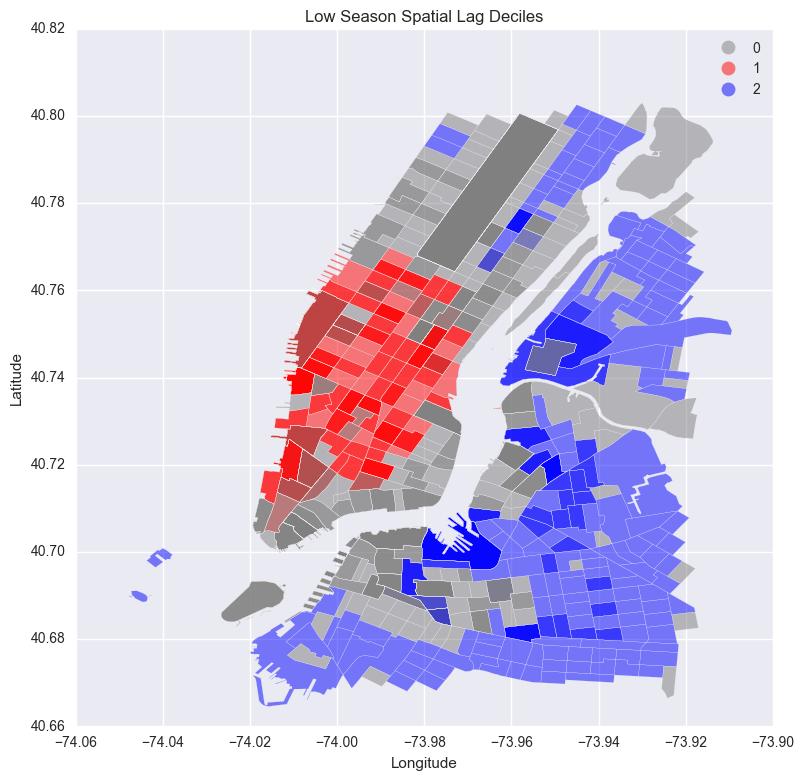

In [69]:
# Low Season Spatial Autocorrelation Analysis
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold1 = hotspots1*1 + coldspots1*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_seasons_zoom.assign(cl=hotcold1).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title("Low Season Spatial Lag Deciles")

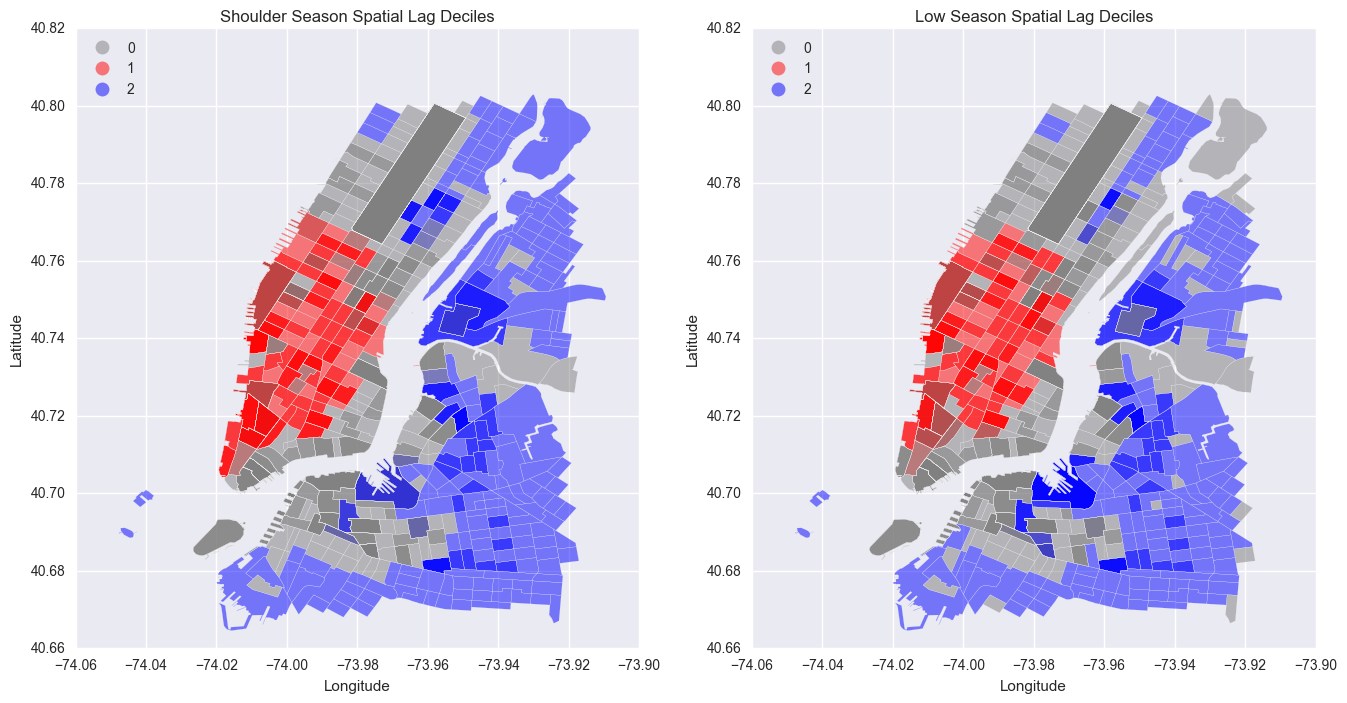

In [70]:
# Make both polts together

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold0 = hotspots0 * 1 + coldspots0 * 2
hotcold1 = hotspots1 * 1 + coldspots1 * 2

fig, ax = plt.subplots(figsize=(16, 8))

ax1 = plt.subplot(121)
ct_shape_seasons_zoom.assign(cl=hotcold0).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax1, 
        edgecolor='white', legend=True)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
plt.title("Shoulder Season Spatial Lag Deciles")

ax2 = plt.subplot(122)
ct_shape_seasons_zoom.assign(cl=hotcold1).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax2, 
        edgecolor='white', legend=True)

ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
plt.title("Low Season Spatial Lag Deciles")


For both plots, the red area represents the hotspot (means high spatial autocorrelation with its neighbors in terms of Queen contigutiy pattern). While the blue area shows the low spatial autocorrelation with its neighbors with different degree in queen pattern, so called it coldspot. Comparing the rideships in both shoulder season and low season, we would say there are not much difference between the two, telling from the similary amounts of hotspots and coldspots created by their distribution patterns.